In [22]:
# compare the data/mc for cluster shape/position, variables used for BDT training

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [23]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
ver = 'V1p17'
sig_ver = 'v151'
year='2017'
singleMuon = True
data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data'+year+'/v5/'+sig_ver+'/normalized/'
bkg_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/'+sig_ver+'/normalized/'


lumi = 41.53*1000


fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root'

fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"


In [24]:
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print (np.unique(a)*lumi)
    print(a.shape)

dy_120_800 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v151/normalized/ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root
[-8.627941  -1.2055961 -0.1042499  0.1042499  1.2055961  8.627941 ]
(143420,)
data /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v151/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
[41530.]
(354744,)


# cluster level variables (matched to probe muon, all mass bins)

In [25]:
%%time

sel_tp = {}
pileupWeight = {}
weight = {}
clusterSize = {}
clusterEta = {}
clusterTimeSpread = {}
clusterTimeTotal = {}
clusterMe11Ratio = {}
clusterMB1Ratio = {}
clusterMatchMB1 = {}
clusterMatchRPC = {}
clusterMaxStation = {}
sel_lep = {}
sel_ev = {}
cut_based = {}
probe_index = {}
sel_tp = {}
cond = {}
mc_corr_weight = {}
cscRechitClusterMaxChamber = {}
ZMass = {}
lepEta = {}
lepE = {}
lepPt = {}
lepPz = {}
muonEta_weight = {}
muonPt = 50
tag_probe = True
norm = False
text = False
scaling = 'norm'
m1, m2 = '120', '800' 
region = 'dt'
for k in ['data_'+m1+'_'+m2]:
    if k[:4] == 'data': T = tree_bkg['data']
    else: T = tree_bkg[k]
    sel_cluster = np.abs(T.array(region+ 'RechitClusterSize'))>=50
    sel_cluster = np.logical_and(sel_cluster, np.logical_or(T.array(region+ 'RechitClusterZLep1') == 1, T.array(region+ 'RechitClusterZLep2') == 1))
    
    if region == 'csc':
        sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterTimeSpread')< 20)
        sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterTimeTotal')< 12.5)
        sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitClusterTimeTotal') > -5)
    
    if tag_probe: 
        sel_cluster1 =np.logical_and(sel_cluster,  T.array(region+ 'RechitClusterZLep1') == 1)   #loose lepton
        sel_cluster2 = np.logical_and(sel_cluster,  T.array(region+ 'RechitClusterZLep2') == 1)  

# ########### BRANCHES ############
    sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
    sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
    sel_ev[k] = sel_lep[k].sum()>=1
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt).sum()==2)
    if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], T.array('lepFromZ').sum()==2)
    sel_ev[k] = np.logical_and(sel_ev[k], T.array("Flag2_all"))
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
    sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
    if m1 == '50':
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=int(60))
    else:
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=int(m1))
    sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<int(m2))
    probe_index[k] = []
    sel_tp[k] = []
    cond[k] = []
    sel_probecluster = []
    pdgid = T.array("lepPdgId")


    index = 0
    for i, ev in enumerate(sel_ev[k]):
        if ev:
            if sel_lep[k][i][0]:
                probe_index[k].append([False,True])
                sel_tp[k].append(index)
                if pdgid[i][0] == 13:
                    cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                    if cond[k][-1]: sel_probecluster.append(sel_cluster2[i])
                else:
                    cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                    if cond[k][-1]:sel_probecluster.append(sel_cluster1[i])
            if sel_lep[k][i][1]:
                probe_index[k].append([True, False])
                sel_tp[k].append(index)
                if pdgid[i][0] == -13:
                    cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                    if cond[k][-1]:sel_probecluster.append(sel_cluster2[i])
                else:
                    cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                    if cond[k][-1]:sel_probecluster.append(sel_cluster1[i])
            index+=1
    sel_tp[k] = np.array(sel_tp[k])
    probe_index[k] = np.array(probe_index[k])

    cond[k] = np.array(cond[k])
    sel_probecluster = awkward.fromiter(sel_probecluster)

    if region == 'csc':
        clusterTimeSpread[k] = awkward.fromiter(T.array('cscRechitClusterTimeSpread')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterTimeTotal[k] = awkward.fromiter(T.array('cscRechitClusterTimeTotal')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMe11Ratio[k] = awkward.fromiter(T.array('cscRechitClusterMe11Ratio')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterSize[k] = awkward.fromiter(T.array('cscRechitClusterMe11Ratio')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]



    else:
        clusterMB1Ratio[k] = awkward.fromiter((T.array('dtRechitClusterNSegmentStation1')/T.array('dtRechitClusterSize'))[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMatchRPC[k] = awkward.fromiter(T.array('dtRechitCluster_match_RPChits_dPhi0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMatchMB1[k] = awkward.fromiter(T.array('dtRechitCluster_match_MB1hits_0p5')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        clusterMaxStation[k] = awkward.fromiter(T.array('dtRechitClusterMaxStation')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]

    clusterSize[k] = awkward.fromiter(T.array(region+ 'RechitClusterSize')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
    clusterEta[k] = awkward.fromiter(T.array(region+ 'RechitClusterEta')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]


    lepEta[k] = np.stack(np.array(T.array('lepEta')[sel_ev[k]][sel_tp[k]]))[probe_index[k]]

    lepPt[k] = np.stack(np.array(T.array('lepPt')[sel_ev[k]][sel_tp[k]]))[probe_index[k]]
    lepE[k] = np.stack(np.array(T.array('lepE')[sel_ev[k]][sel_tp[k]]))[probe_index[k]]
    lepPz[k] = np.sinh(np.array(lepEta[k]).astype(np.float64))*lepPt[k]








CPU times: user 1min 13s, sys: 1.34 s, total: 1min 14s
Wall time: 1min 17s


# cluster efficiency wrt eta

/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/
43703.0 671930.0
/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/dtclusterEff_eta_Nrechit50
6641.0 671930.0
/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/dtclusterEff_eta_Nrechit80
3108.0 671930.0
/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/dtclusterEff_eta_Nrechit100


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/dtclusterEff_eta_Nrechit50.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/dtclusterEff_eta_Nrechit50.C has been generated
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing

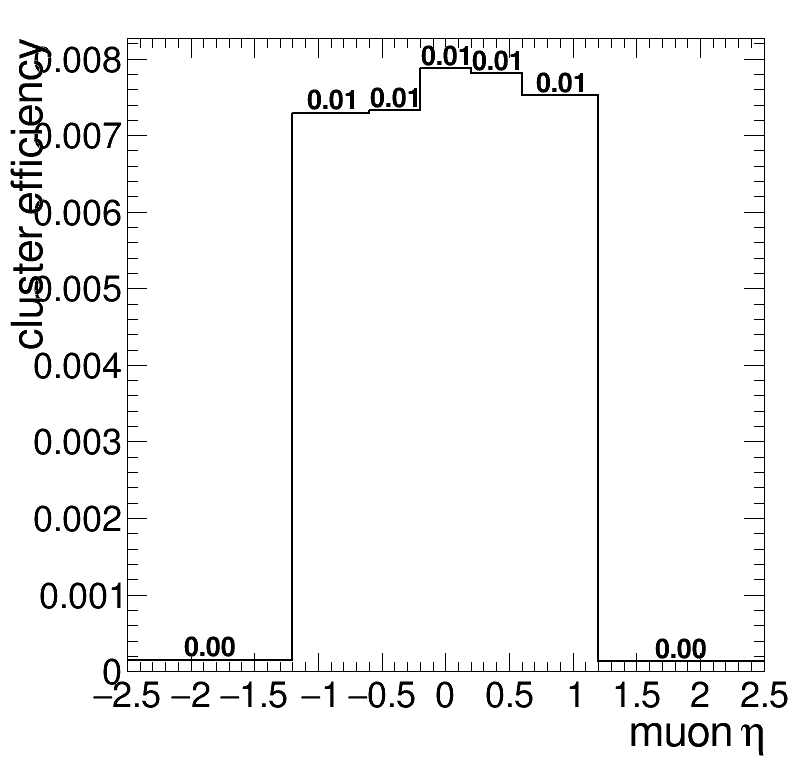

In [26]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


rt.gStyle.SetOptFit(1011)
dir_name = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/'

if not os.path.isdir(dir_name):os.makedirs(dir_name)
print(dir_name)


norm = 1
fit = 0
k='data_'+m1+'_'+m2
# eta_bins = [25,-2.5,2.5]
if region == 'csc':eta_bins = [-2.5, -1.9, -0.8, 0.8, 1.9, 2.5]
else: eta_bins = [-2.5,-1.2, -0.6, -0.2, 0.2, 0.6, 1.2, 2.5 ]

# Nrechit_cut = 50
for Nrechit_cut in [50,80,100]:
#     if not Nrechit_cut == 50:continue
        
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    rt.gStyle.SetPaintTextFormat("4.2f");

    hm = create_TH1D( lepEta[k][cond[k]][clusterSize[k]>Nrechit_cut], axis_title=['muon #eta', 'cluster efficiency'], name=k, binning=eta_bins)
    hb = create_TH1D( lepEta[k], axis_title=['muon #eta', 'cluster efficiency'], name=k, binning=eta_bins)
    print(hm.Integral(), hb.Integral())
    eff = rt.TEfficiency(hm,hb)
    hist = hm.Clone()
    for i in range(hm.GetNbinsX()):
        hist.SetBinContent(i+1, eff.GetEfficiency(i+1))

    hist.SetLineWidth(2)
    hist.Draw()
    hist.SetMarkerSize(1.9)
    hist.Draw('same TEXT0')



    c.Draw()

    file_name = dir_name+region+'clusterEff_eta'+'_Nrechit'+str(Nrechit_cut)
    print(file_name)
    c.SaveAs(file_name+".png")
    c.SaveAs(file_name+".C")


/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/clusterSize_eta_n2p5_n1p9
/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/clusterSize_eta_n1p9_n0p8
/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/clusterSize_eta_0p8_1p9
/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/clusterSize_eta_1p9_2p5


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/clusterSize_eta_n2p5_n1p9.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/clusterSize_eta_n2p5_n1p9.C has been generated
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/HLT/clusterSize_eta_n1p9_n0p8.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /stor

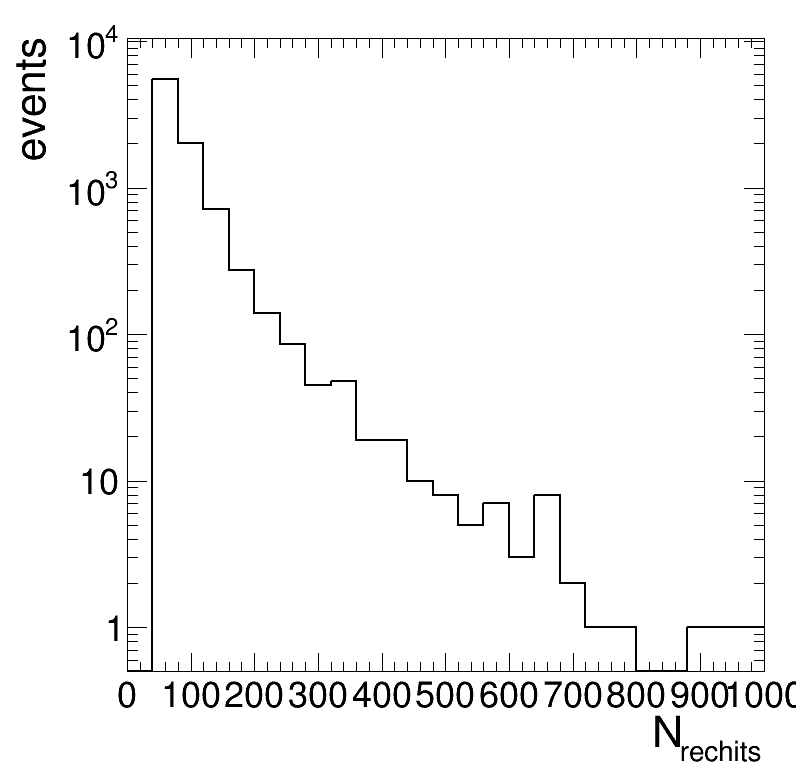

In [127]:
# plot number of matched clusters wrt eta

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


k='data_'+m1+'_'+m2
test = [25,-2.5,2.5]
binwidth = (eta_bins[2]-eta_bins[1])/eta_bins[0]


h = {}

for i, leftEdge in enumerate(eta_bins):
    if leftEdge == eta_bins[-1]:continue
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    rightEdge = eta_bins[i+1]
    cut = np.logical_and(clusterEta[k]<rightEdge, clusterEta[k]>=leftEdge)
    h[leftEdge] = create_TH1D( clusterSize[k][cut], axis_title=['N_{rechits}', 'events'], name=k, binning=[25,0,1000])
    if h[leftEdge].Integral()==0:continue
    h[leftEdge].SetLineWidth(2)

#     h[leftEdge].SetLineColor(std_color_list[i])

    h[leftEdge].Draw()
    i += 1
    c.SetLogy()
    c.Draw()

    strLeftEdge = str(round(leftEdge, 1)).replace('.', 'p').replace('-', 'n')
    strRightEdge = str(round(rightEdge, 1)).replace('.', 'p').replace('-', 'n')


        
    file_name = dir_name+'clusterSize_eta_'+strLeftEdge+'_'+strRightEdge
    print(file_name)
    c.SaveAs(file_name+".png")
    c.SaveAs(file_name+".C")



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: data_120_800 (Potential memory leak).
Warning in <TROOT::Append>: Rep

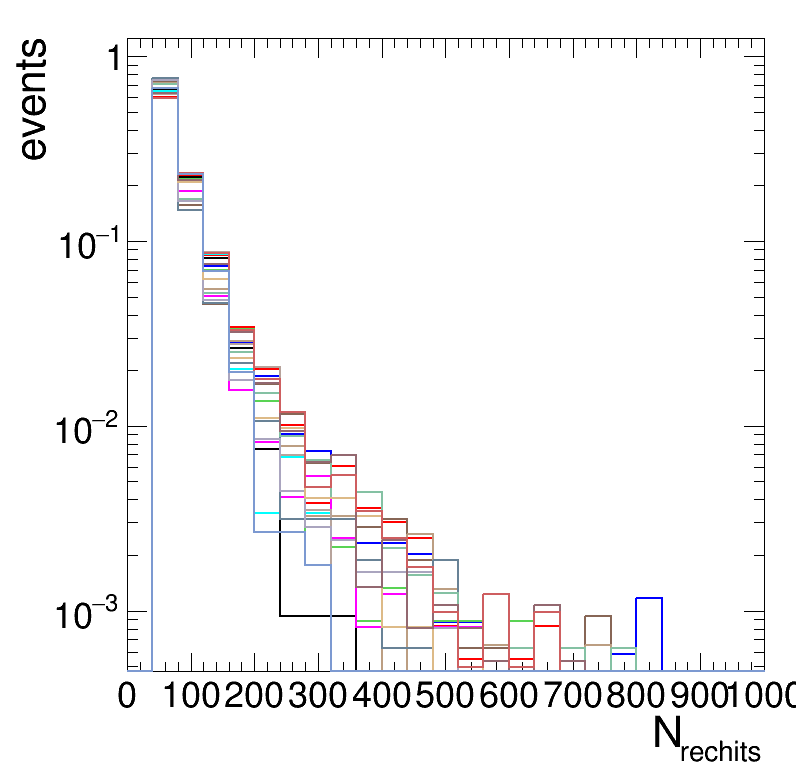

In [54]:
# plot number of matched clusters wrt eta

import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff


k='data_'+m1+'_'+m2
test = [25,-2.5,2.5]
binwidth = (eta_bins[2]-eta_bins[1])/eta_bins[0]
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)

h = {}
i = 0
for leftEdge in np.arange(-2.5,2.5,binwidth):
    
    rightEdge = leftEdge+binwidth
    cut = np.logical_and(clusterEta[k]<rightEdge, clusterEta[k]>leftEdge)
    h[leftEdge] = create_TH1D( clusterSize[k][cut], axis_title=['N_{rechits}', 'events'], name=k, binning=[25,0,1000])
    if h[leftEdge].Integral()==0:continue
    h[leftEdge].SetLineWidth(2)

    h[leftEdge].SetLineColor(std_color_list[i])

    h[leftEdge].DrawNormalized('same')
    i += 1
c.SetLogy()
c.Draw()

# strLeftEdge = str(round(leftEdge, 1)).replace('.', 'p').replace('-', 'n')
# strRightEdge = str(round(rightEdge, 1)).replace('.', 'p').replace('-', 'n')



# file_name = dir_name+'clusterSize_eta_'+strLeftEdge+'_'+strRightEdge
# print(file_name)
# c.SaveAs(file_name+".png")
# c.SaveAs(file_name+".C")


